# BINF GU 4002: Machine Learning for Healthcare, Spring 2025
# Assignment \#2: Regularization and Model Selection
## DUE: 11:59 PM, Tuesday, March 11, 2025

This assignment explores regularization and model selection. We will use ideas explored in class and build intuition around how to select appropriate modelling techniques for the specific data and task you have. As an illustrative example, you will be using embeddings generated from a large-scale protein language model to predict the structural effects of a mutation in the protein sequence.

**<font color="red">Instructions: Please run the notebook using Google Colab to prevent any dependency / package issues. Make sure that your written answers are formatted using </font>$\LaTeX$<font color="red"> in `markdown` cells. When submitting, please name your files `{UNI}_binf4002_mlhc_assignment_2.{filetype}` and submit a `.ipynb` version of your Jupyter notebook. Additionally, we will render the jupyter notebook using nbviewer (https://nbviewer.org/). When you are submitting your final version, upload your homework to a public github repository and paste the github link to nbviewer and obtain the final rendered link </font>**

Link to github repository:

Link to nbviewer render:

#### The Problem and Data

We will be using data from the [Envision](https://pmc.ncbi.nlm.nih.gov/articles/pmid/29226803/) paper (Gray et al.2018). The goal is to perform variant effect prediction, where variants of β-Lactamase are created by through single-residue mutations (one amino-acid is replaced by another amino-acid in the protein sequence). The data is generated using a method called deep mutational scan.

From Gray et al. 2018:

> In a deep mutational scan, selection for protein function among a library of nearly all possible single amino acid variants of a protein is coupled to high-throughput DNA sequencing (Fowler and Fields, 2014; Fowler et al., 2014). Sequencing reveals how each variant’s frequency changes during selection, yielding quantitative scores that describe the functional effect of each variant in the library. A large-scale mutagenesis dataset contains deep and unbiased information, capturing the effects of most variants at every position in a single protein. We hypothesize that large-scale mutagenesis datasets contain informative and generalizable patterns that can be used to predict variant effects in disparate proteins.

The prediction target is a quantitative metric known as variant effect score, which depends on the protein of interest. For example, this score may capture the severity of functional disruption.

The embeddings are generated from [ESM](https://www.nature.com/articles/s41588-023-01465-0), a large-scale language (foundation) model for protein sequences developed by Meta AI. The repository can be found here: https://github.com/facebookresearch/esm/tree/main  

In [1]:
# STARTER CODE
!pip install git+https://github.com/facebookresearch/esm.git
!curl -O https://dl.fbaipublicfiles.com/fair-esm/examples/P62593_reprs.tar.gz
!tar -xzf P62593_reprs.tar.gz
!curl -O https://dl.fbaipublicfiles.com/fair-esm/examples/P62593.fasta
!pwd
!ls

FASTA_PATH = "/content/P62593.fasta" # Path to P62593.fasta
EMB_PATH = "/content/P62593_reprs" # Path to directory of embeddings for P62593.fasta
EMB_LAYER = 34

  Cloning https://github.com/facebookresearch/esm.git to /tmp/pip-req-build-qhpkam4s
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/esm.git /tmp/pip-req-build-qhpkam4s
  Resolved https://github.com/facebookresearch/esm.git to commit 2b369911bb5b4b0dda914521b9475cad1656b2ac
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for fair-esm: filename=fair_esm-2.0.1-py3-none-any.whl size=105419 sha256=9d64546bc02f34e21d012db8c7b89c3eec9e8e85c43c979d7c58a9bc5e1f431b
  Stored in directory: /tmp/pip-ephem-wheel-cache-plj1x9ik/wheels/73/b8/59/2a3415340d3dec5ae3d9ce69f8d7eb22674be68a4402b39f7a
Successfully built fair-esm
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 24.5M  100 24.5M    0     0  40.2M      0 --:--:-- --:--:-- --:--:-- 40.2M
 

In [2]:
import random
from collections import Counter
from tqdm import tqdm

import torch
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

import scipy
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.decomposition import PCA

import esm

ys = []
Xs = []

for header, _seq in esm.data.read_fasta(FASTA_PATH):
    scaled_effect = header.split('|')[-1]
    ys.append(float(scaled_effect))
    fn = f'{EMB_PATH}/{header}.pt'
    embs = torch.load(fn)
    Xs.append(embs['mean_representations'][EMB_LAYER])

Xs = torch.stack(Xs, dim=0).numpy()

train_size = 0.8
Xs_train, Xs_test, ys_train, ys_test = train_test_split(Xs, ys, train_size=train_size, random_state=42)

print(Xs.shape)

<ipython-input-2-e907ffff8eb5>:24: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  embs = torch.load(fn)


(5397, 1280)


#### Data exploration

Note that the embeddings are high-dimensional. To qualitatively analyse if there are patterns (ex. naturally-forming clusters) in the data, we can visualize the data using dimensionality reduction. The color indicates the level of functional distruption in the protein, and each point represents a different amino-acid sequence containing a specific mutation.

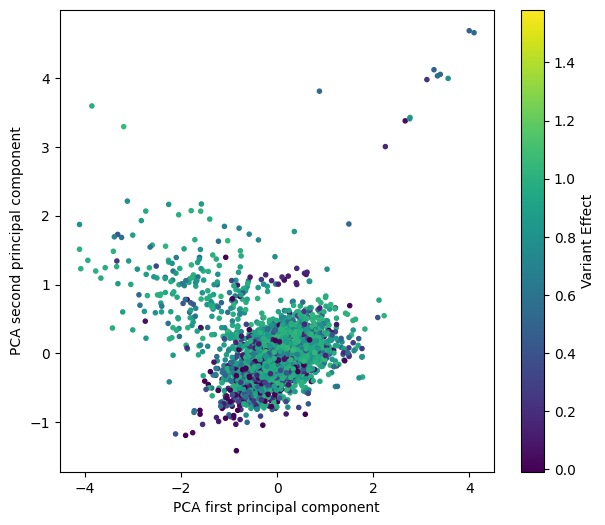

In [3]:
num_pca_components = 60
pca = PCA(num_pca_components)
Xs_train_pca = pca.fit_transform(Xs_train)

fig_dims = (7, 6)
fig, ax = plt.subplots(figsize=fig_dims)
sc = ax.scatter(Xs_train_pca[:,0], Xs_train_pca[:,1], c=ys_train, marker='.')
ax.set_xlabel('PCA first principal component')
ax.set_ylabel('PCA second principal component')
plt.colorbar(sc, label='Variant Effect')
plt.show()

## [30 Points] Question 1: Bias Variance Tradeoff

Modeling data in healthcare is often in a data-constrained setting, where we may be restricted to high dimensional data with limited samples due to costs of experimentation and data acquisition. However, a key desiderata for our models is the ability to generalize to unseen samples.

How do we know if we have enough data for a given modelling task to achieve generalization? How do we choose the right modeling strategy? We will explore these questions using a phenomenon in machine learning known as the bias-variance tradeoff.

Consider a dataset $$D = \{(x_1, y_1), (x_2, y_2), ..., (x_n, y_n) \}$$

and suppose that the relationship between $x \in \mathbb{R}^1$ and $y \in \mathbb{R}^1$ values are specified by an unknown true underlying function as $y = f(x) + \epsilon$ where $\epsilon \sim N(0, \sigma^2)$.

Now, suppose we have trained an approximation of the underlying true function using the training dataset with $\hat{y} = \hat{f}(x)$, where $\hat{y}$ corresponds to the prediction of $y$

#### [15 Points] 1.1: Prove the bias-variance decomposition of mean squared error
$$\mathbb{E}_{D} \left[(y - \hat{f}(x) )^2\right] = \underbrace{\left(\mathbb{E}\left[\hat{f}(x) \right] - f(x) \right)^2}_{Bias^2} + \underbrace{\mathbb{E}_{D}\left[\left(\hat{f}(x) - \mathbb{E}\left[\hat{f}(x)\right] \right)^2 \right]}_{Variance}$$

**Answer:**
Given the definition of variance and bias, we know that
- Bias is the difference bewteen the average value of the prediction and the true value:
$$\text{Bias}(\hat{f}(x))=\mathbb{E}\left[\hat{f}(x)\right]-f(x) $$
- Variance shows how much the data points in a dataset differ from the mean (average) value:
$$
\text{Var}(\hat{f}(x))=\mathbb{E}\left[ (\hat{f}(x)-\mathbb{E}\left[\hat{f}(x) \right])^2\right]
$$

Expand the MSE:
$$
\mathbb{E}_{D} \left[(y - \hat{f}(x) )^2\right] =\mathbb{E}_{D} \left[(f(x) + \epsilon - \hat{f}(x) )^2\right]
$$
Introduce the expected value $\mathbb{E}\left[\hat{f}(x)\right]$ to MSE:
$$
= \mathbb{E}_{D} \left[(f(x) - \mathbb{E}\left[\hat{f}(x)\right] + \mathbb{E}\left[\hat{f}(x)\right] - \hat{f}(x) + \epsilon)^2\right]
$$
Group and apply square:
$$
= \mathbb{E}_{D} \left[(f(x) - \mathbb{E}\left[\hat{f}(x)\right])^2 + (\mathbb{E}\left[\hat{f}(x)\right] - \hat{f}(x))^2  + \epsilon^2 + 2(f(x) - \mathbb{E}\left[\hat{f}(x)\right])(\mathbb{E}\left[\hat{f}(x)\right] - \hat{f}(x)) + 2(f(x)-\mathbb{E}\left[\hat{f}(x)\right])\epsilon + 2(\mathbb{E}\left[\hat{f}(x)\right]-\hat{f}(x))\epsilon \right]
$$


Apply the linearity of expectation:
$$
= \mathbb{E}_{D} \left[(f(x) - \mathbb{E}\left[\hat{f}(x)\right])^2\right] + \mathbb{E}_{D} \left[(\mathbb{E}\left[\hat{f}(x)\right] - \hat{f}(x))^2\right]  + \mathbb{E}_{D} \left[ \epsilon^2\right] + \mathbb{E}_{D} \left[2(f(x) - \mathbb{E}\left[\hat{f}(x)\right])(\mathbb{E}\left[\hat{f}(x)\right] - \hat{f}(x))\right] + \mathbb{E}_{D} \left[2(f(x)-\mathbb{E}\left[\hat{f}(x)\right])\epsilon\right] + \mathbb{E}_{D} \left[2(\mathbb{E}\left[\hat{f}(x)\right]-\hat{f}(x))\epsilon \right] $$

Expand the middle term:
$$
\begin{align}
\mathbb{E}_{D} \left[2(f(x) - \mathbb{E}\left[\hat{f}(x)\right])(\mathbb{E}\left[\hat{f}(x)\right] - \hat{f}(x))\right]\\
&= 2\mathbb{E}_{D} \left[ f(x)\mathbb{E}\left[\hat{f}(x)\right] -f(x)\hat{f}(x) -\mathbb{E}\left[\hat{f}(x)\right]^2+\mathbb{E}\left[\hat{f}(x)\right]\hat{f}(x) \right]\\
&= 2 \left(f(x)\mathbb{E}\left[\hat{f}(x)\right]-f(x)\mathbb{E}\left[\hat{f}(x)\right]-\mathbb{E}\left[\hat{f}(x)\right]^2+\mathbb{E}\left[\hat{f}(x)\right]^2 \right)\\
&=0
\end{align}
$$

Given $\epsilon \sim N(0, \sigma^2)$, we know that $\mathbb{E}[\epsilon]=0$ and $\mathbb{E}[\epsilon^2]=\sigma^2$. Then we arrive:
$$
\mathbb{E}_{D} \left[(y - \hat{f}(x) )^2\right]= \underbrace{\mathbb{E}_{D} \left[(f(x) - \mathbb{E}\left[\hat{f}(x)\right])^2\right]}_{Bias^2} + \underbrace{\mathbb{E}_{D} \left[(\mathbb{E}\left[\hat{f}(x)\right] - \hat{f}(x))^2\right]}_{Variance}  + \sigma^2
$$

where $\sigma^2$ is the irreducible error due to noise in the data.


#### [5 Points] 1.2: What does it mean for the prediction model $\hat{f}(x)$ to have high bias? What are potential causes of high bias?
**Answer:**

Based on the definition of bias--how far the expected prediction $\mathbb{E}_{D}\left[\hat{f}(x)\right]$ is from the true value $y$, a high bias indicates the model's predictions are not very accurate and underfitting as the predicted values are largely different from the true values.

Potential causes of high bias include:
1. Too simple model such as using a linear relationship to fit data with nonliear relationship.
2. Insufficient features. Not including enough relevant features in the model so that the model cannot capture the true relationship.
3. Over-regularization by using a high regularization parameter.



#### [5 Points] 1.3: What does it mean for the model to have high variance? What are potential causes of high variance?
**Answer:**

Based on the definition of variance--how much the  prediction $\hat{f}(x)$ vary around their expected value $\mathbb{E}_{D}\left[\hat{f}(x)\right]$, a high variance indicates overfitting.

Potential causes of high bias include:
1. Too complex model that fits the training data very well.
2. Too many features, including irrelevant or redundant ones.
3. Insufficient regularization.

#### [5 Points] 1.4 Can bias and variance decrease at the same time?
**Answer:**

From the bias-variance trade-off relationship, bias and variance cannot decrease at the same time for the same training set. However, if we increase the size of training data, they might get decreased simultaneously.

# [30 Points] Question 2: Regularization

A model with high bias is also called "underfitting", while a model with high variance is also called "overfitting". One idea from the bias-variance tradeoff is that purposefully introducing bias may be an effective strategy in mitigating overfitting and reducing variance.

We will now explore regularization, a common strategy used to introduce bias in the model to improve generalization.

Consider a dataset $$D = \{(\textbf{x}_1, y_1), (\textbf{x}_2, y_2), ..., (\textbf{x}_n, y_n) \}$$

where now each sample contains a vector of $d$ features $\textbf{x}_i \in \mathbb{R}^{d \times 1}$

Suppose we specifiy our model to be a linear regression model. That is, we consider a model with a vector of parameters $\beta \in \mathbb{R}^{d \times 1}$ such that $y_i = \textbf{x}_i^T \beta + \epsilon $

Note that we can equivalently write the set of $n$ equations stacked together using a matrix $\textbf{X} \in \mathbb{R}^{n \times d}$ and $\textbf{y} \in \mathbb{R}^{n \times 1}$ as follows:

$$\textbf{y} = \textbf{X} \beta + \epsilon \text{ , } \quad \epsilon \sim N(0, \sigma^2 I)$$

#### [10 Points] Question 2.1: Derive the optimal solution to the L2-regularized Squared Error Loss (also known as ridge regression) given by

$$(\textbf{X}\beta - \textbf{y})^T(\textbf{X}\beta - \textbf{y}) + \lambda \beta^T\beta $$

**Answer:**

Let $$\begin{align}
L(\beta)\\
&=(\textbf{X}\beta - \textbf{y})^T(\textbf{X}\beta - \textbf{y}) + \lambda \beta^T\beta \\
&=(\textbf{X}\beta)^T(\textbf{X}\beta)-(\textbf{X}\beta)^Ty-y^T\textbf{X}\beta+y^Ty + \lambda \beta^T\beta\\
&=\beta^T\textbf{X}^T\textbf{X}\beta-\beta^T\textbf{X}^Ty-y^T\textbf{X}\beta+y^Ty + \lambda \beta^T\beta\\
&=\beta^T\textbf{X}^T\textbf{X}\beta-2y^T\textbf{X}\beta+y^Ty + \lambda \beta^T\beta\\
\end{align}
$$
Take the derivative of $L(\beta)$ with respect to $\beta$ and set it to 0:
$$\frac{\partial{L(\beta)}}{\partial{\beta}}=(\textbf{X}\textbf{X}^T+\textbf{X}^T\textbf{X})\beta - 2\textbf{X}^Ty  + 2\lambda \beta = 0
$$
Note that $\textbf{X}^T\textbf{X}$ is symmetric as $(\textbf{X}^T\textbf{X})^T=\textbf{X}^T\textbf{X}$.
$$\frac{\partial{L(\beta)}}{\partial{\beta}}=(2\textbf{X}^T\textbf{X})\beta - 2\textbf{X}^Ty  + 2\lambda \beta = 0
$$

$$
2(\textbf{X}^T\textbf{X}+2\lambda I)\beta = 2\textbf{X}^Ty
$$
$$
\beta = (\textbf{X}^T\textbf{X}+\lambda I)^{-1} \textbf{X}^Ty
$$


#### [15 Points] Question 2.2: Build a Ridge Regression with the skeleton code below (Fill in TODOs).

#### [5 Points] Question 2.3: What do you notice in the relationship between MSE and variance as we increase the lambda parameter?

**Answer:**

As lambda increases, the regularization term becomes more dominant, forcing the model coefficients $\beta$ to shrink smaller and smaller, the variance of the model drops. MSE first drops; until a certain point (around lambda=10), it increases as lambda increases.

In [4]:
class RidgeRegression:
    def __init__(self, lambda_reg=1.0):
        self.lambda_reg = lambda_reg  # Regularization parameter
        self.beta = None  # Coefficients

    def fit(self, X, y):
        """ Compute the closed-form solution for Ridge Regression. """
        n, d = X.shape
        I = np.eye(d)  # Identity matrix
        XTX = X.T @ X  # Compute X^T X
        XTy = X.T @ y  # Compute X^T y

        # Closed-form solution
        self.beta = np.linalg.inv(XTX+self.lambda_reg*I)@XTy# TODO: Fill in

    def predict(self, X):
        """ Predict using the learned weights. """
        return X @ self.beta

    def mse(self, y_true, y_pred):
        """ Compute Mean Squared Error (MSE). """
        mse = np.mean((y_pred-y_true)**2)
        return mse # TODO: Compute MSE

In [5]:
# Define a range of lambda values
lambdas = np.logspace(-3, 3, 30)  # From 0.001 to 1000
mse_values = []
variance_values = []

# Compute bias and variance for each lambda
for lambda_reg in lambdas:
    model = RidgeRegression(lambda_reg)
    model.fit(Xs_train, ys_train)

    predictions = model.predict(Xs_test)
    mse = np.mean((ys_test - predictions) ** 2)
    variance = np.var(predictions)

    mse_values.append(mse)
    variance_values.append(variance)

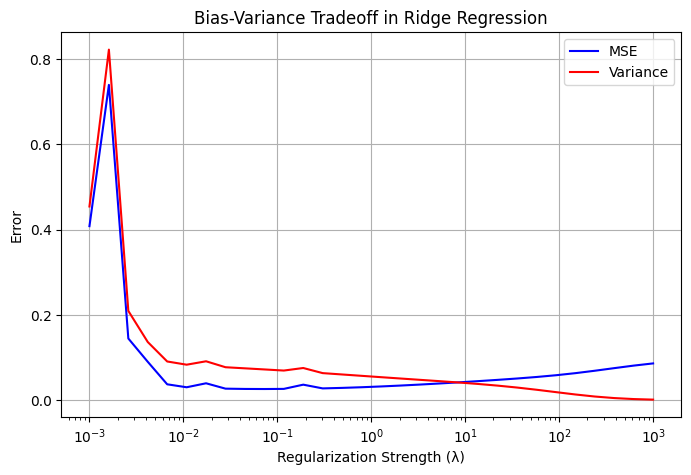

In [6]:
# Plotting Code for question 2.3

plt.figure(figsize=(8, 5))
plt.plot(lambdas, mse_values, label="MSE", color='blue')
plt.plot(lambdas, variance_values, label="Variance", color='red')
plt.xscale('log')  # Log scale for better visualization
plt.xlabel("Regularization Strength (λ)")
plt.ylabel("Error")
plt.title("Bias-Variance Tradeoff in Ridge Regression")
plt.legend()
plt.grid()
plt.show()

# [20 Points] Question 3: Bayesian Variable Selection

Follwing the intuition we have built around regularization, we will now explore a more complex Bayesian model for the protein variant effect prediction task. We assume the same linear model with the same dimensionality as before

$$\textbf{y} = \textbf{X} \beta + \epsilon \text{ , } \quad \epsilon \sim N(0, \sigma^2 I)$$

However, now we will introduce a prior on the model parameters $\beta$. For each $\beta_j$ where $j=1, ..., d$, the prior takes the following form

$$ \beta_j | \gamma_j \sim (1 - \gamma_j)\cdot 0 + \gamma_j N(0, \sigma_\beta^2) \text{ , } \quad \gamma_j \sim \text{Bernoulli}(p)$$

Equivalently, we can rewrite the resulting model in a slightly more compact form where $\circ$ indicates a element-wise (hadamard) product between two vectors.

$$ \beta \sim N(0, \sigma_\beta^2) $$
$$ \textbf{y}_i | \textbf{x}_i, \beta, \gamma \sim N((\gamma \circ \beta)^T \textbf{x}_i, \sigma^2)$$


#### [5 Points] 3.1: What is the role of the $\gamma$ parameter in determining $\beta$ in the prior? What happens when $\gamma = 1$ and $\gamma = 0$?

**Answer:**

The $\gamma$ parameter determines the distribution of $\beta$.

Given $ \beta_j | \gamma_j \sim (1 - \gamma_j)\cdot 0 + \gamma_j N(0, \sigma_\beta^2) \text{ , } \quad \gamma_j \sim \text{Bernoulli}(p)$:

-  When $\gamma_j=1$, we have $\beta_j | \gamma_j \sim  N(0, \sigma_\beta^2)$. It indicates that $\beta_j$ is drawn from a normal distribution and non-zero $\beta_j$ will contribute to model.
-  When $\gamma_j=0$, we have $\beta_j | \gamma_j \sim  0$, that is $\beta_j=0$. Then the corresponding feature does not contribute to the model prediction.

#### [10 Points] 3.2: We would like to fit the parameters $\gamma, \beta$ using MAP estimation. Write the posterior objective $p(\gamma, \beta | \textbf{X}, \textbf{y})$ in terms of the priors and likelihoods. (We will assume $\sigma^2$ is fixed for purposes of this problem)

Hints: Recall the posterior probability we wish to maximize given data is $p(\theta | \text{X}, \text{y}) \propto p(\theta) \prod_i^n p(y_i |x_i, \theta) $. What are the distributional families of the priors and likelihoods?

**Answer:**

Use Baye's Rule:
$$p(\gamma, \beta | \textbf{X}, \textbf{y})=\frac{p(\textbf{X}, \textbf{y}|\gamma, \beta)p(\gamma, \beta)}{p(\textbf{X}, \textbf{y})}$$

Since $\textbf{X}$ is independent from $\gamma$ and $\beta$, we can simplify the posterior likehood to be:
$$p(\gamma, \beta | \textbf{X}, \textbf{y})=\frac{p(\textbf{y}|\textbf{X},\gamma, \beta)p(\gamma, \beta)}{p(\textbf{X}, \textbf{y})}$$

For MAP, we only care about $\gamma, \beta$, so we can ignore the term $p(\textbf{X}, \textbf{y})$. Then consider the log of the posterior distribution, we have:
$$\log p(\gamma, \beta | \textbf{X}, \textbf{y})=\log p(\textbf{y}|\textbf{X},\gamma, \beta)+ \log p(\gamma, \beta)$$

Given $ \textbf{y}_i | \textbf{x}_i, \beta, \gamma \sim N((\gamma \circ \beta)^T \textbf{x}_i, \sigma^2)$, the first term would become:
$$
\begin{align}
\log p(\textbf{y}|\textbf{X},\gamma, \beta)\\
&= \log \prod^{N}_{i=1}p(y_i|\textbf{X},\gamma, \beta)\\
&=\sum^{N}_{i=1}\log\left[ \frac{1}{\sqrt{2\pi \sigma^2}} \text{exp}\left( - \frac{(y_i-(\gamma \circ \beta)^T \textbf{x}_i)^2}{2\sigma^2}\right) \right]\\
&=N\log\frac{1}{\sqrt{2\pi \sigma^2}} + \sum^{N}_{i=1}\log\left( - \frac{(y_i-(\gamma \circ \beta)^T \textbf{x}_i)^2}{2\sigma^2}\right)\\
&\propto \log\left( - \frac{(y_i-(\gamma \circ \beta)^T \textbf{x}_i)^2}{2\sigma^2}\right)
\end{align}
$$

The prior $p(\gamma, \beta) = p(\beta|\gamma)p(\gamma) = \prod^{d}_{j=1}p(\beta_j|\gamma_j)p(\gamma_j)$.

Given $\beta_j | \gamma_j \sim (1 - \gamma_j)\cdot 0 + \gamma_j N(0, \sigma_\beta^2) \text{ , } \quad \gamma_j \sim \text{Bernoulli}(p)$, we can derive $\log \prod^{d}_{j=1}p(\beta_j|\gamma_j)p(\gamma_j)$:

$$
\begin{align}
\log \prod^{d}_{j=1}p(\beta_j|\gamma_j)p(\gamma_j)\\
&=\sum^{d}_{j=1} \log p(\beta_j|\gamma_j) + \log p(\gamma_j)\\
&=\sum^{d}_{j=1} \log \left[p(\beta_j|\gamma_j=1)+p(\beta_j|\gamma_j=0)\right] + \log \prod^{d}_{j=1}p^{\gamma_j}(1-p)^{1-\gamma_j}\\
&=\sum^{d}_{j=1} \log \left[\gamma_j \frac{1}{\sqrt{2\pi \sigma_\beta^2}} \text{exp}\left( - \frac{\beta_j^2}{2\sigma_\beta^2}\right)+(1-\gamma_j)\delta_0(\beta_j)\right] + \sum^{d}_{j=1}\log p^{\gamma_j}(1-p)^{1-\gamma_j}\\
&=\sum^{d}_{j=1} \log \left[\gamma_j \frac{1}{\sqrt{2\pi \sigma_\beta^2}} \text{exp}\left( - \frac{\beta_j^2}{2\sigma_\beta^2}\right)+(1-\gamma_j)\delta_0(\beta_j)\right] + \sum^{d}_{j=1}\gamma_j \log p + (1-\gamma_j)\log (1-p)\\
\end{align}
$$
Therefore, combine both terms:
$$
\log p(\gamma, \beta | \textbf{X}, \textbf{y}) = \log\left( - \frac{(y_i-(\gamma \circ \beta)^T \textbf{x}_i)^2}{2\sigma^2}\right) + \sum^{d}_{j=1} \log \left[\gamma_j \frac{1}{\sqrt{2\pi \sigma_\beta^2}} \text{exp}\left( - \frac{\beta_j^2}{2\sigma_\beta^2}\right)+(1-\gamma_j)\delta_0(\beta_j)\right] + \sum^{d}_{j=1}\gamma_j \log p + (1-\gamma_j)\log (1-p)
$$

#### [5 Points] 3.3: Run the code below to obtain the MAP estimate of the optimal parameters of $\gamma$. Interpret the plot. What does the posterior $p(\gamma_j = 1 | \textbf{X}, \textbf{y})$ being high or low indicate for a given $j \in \{1, ..., d\}$?

**Answer:**

The x-axis represents the index of the features $x_1, x_2, \ldots, x_j$. The y-axis represents the MAP estimate of $\gamma_j$, the probability that feature $x_j$ included in the model. Across over 1200 features, where there is a gap (no blue line), it indicates that its corresponding feature doesn't contribute to the model, which means this feature is more likely to be irrelevant for predicting $\textbf{y}$. In contrast, some features have higher probabily (about 0.7), they are more likely to be relevant for model prediction. Therefore, The MAP estimate is helpful in feature selection.

In [3]:
import pymc as pm

num_features = Xs_train.shape[1]

# Bayesian model with spike-and-slab prior (note this takes around 5 minutes)
# Note that in 3.2, the expression cannot be optimized analytically with a closed form solution.
# The following code uses an iterative gradient decsent optimization procedure to find a local maximum

with pm.Model() as model:
    logit_gamma = pm.Normal("logit_gamma", mu=0, sigma=1, shape=num_features)
    gamma = pm.Deterministic("gamma", pm.math.sigmoid(logit_gamma))  # Continuous approximation of bernoulli to speed up gradient-based optimization

    beta = pm.Normal("beta", mu=0, sigma=1, shape=num_features) * gamma
    sigma = pm.HalfNormal("sigma", sigma=1) # This is a normal distribution but only takes positive values (positive half of a normal distribution)

    mu = pm.math.dot(Xs_train, beta)
    y_obs = pm.Normal("y_obs", mu=mu, sigma=sigma, observed=ys_train)

    map_estimate = pm.find_MAP()


Output()

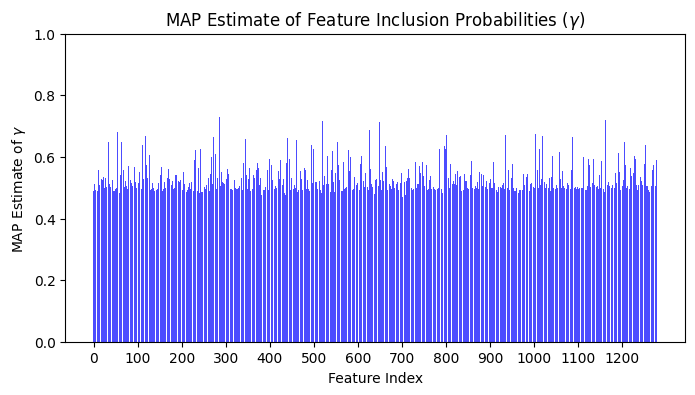

In [4]:
gamma_map = map_estimate["gamma"]

# Plot the MAP estimate of gamma
plt.figure(figsize=(8, 4))
plt.bar(np.arange(len(gamma_map)), gamma_map, color="blue", alpha=0.7)
plt.xlabel("Feature Index")
plt.ylabel("MAP Estimate of $\gamma$")
plt.title("MAP Estimate of Feature Inclusion Probabilities ($\gamma$)")
plt.xticks(np.arange(0, len(gamma_map), 100))
plt.ylim(0, 1)  # Since gamma is in (0,1)
plt.show()

# [10 Points] Question 4: Model Selection & Cross Validation

Using the intuition we have built around regularization, we will now explore practical strategies for selecting the best parameters for a model. We will use the following function to perform cross validation

https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html

#### [10 Points] 3.1: Define a range of parameters and number of cross validation folds. Report the best parameter and mean squared error obtained on the held-out testing data

In [10]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error

ridge_model = Ridge()

# Define hyperparameter grid for Ridge Regression (This is only graded on completion and not on model performance)
param_grid = {'alpha': np.logspace(-3, 3, 30)} #TODO: Fill in  # From 0.001 to 1000
#print(param_grid)
# Perform GridSearchCV with 3-fold cross-validation
grid_search = GridSearchCV(estimator=ridge_model, param_grid=param_grid, cv=3, scoring='neg_mean_squared_error')#TODO: Fill in
grid_search.fit(Xs_train, ys_train)
print("Best parameter (alpha):", grid_search.best_params_)
y_pred = grid_search.predict(Xs_test)
mse = mean_squared_error(ys_test, y_pred)
print("Mean Squared Error on held-out test data:", mse)

/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_ridge.py:215: LinAlgWarning: Ill-conditioned matrix (rcond=4.09577e-08): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_ridge.py:215: LinAlgWarning: Ill-conditioned matrix (rcond=4.57121e-08): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_ridge.py:215: LinAlgWarning: Ill-conditioned matrix (rcond=4.26944e-08): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_ridge.py:215: LinAlgWarning: Ill-conditioned matrix (rcond=4.54273e-08): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_ridge.py:215: LinAlgWarnin

Best parameter (alpha): {'alpha': 0.11721022975334805}
Mean Squared Error on held-out test data: 0.025912748649716377
